# Player Similarity Model

## Background
My dad and I have followed hockey closely but in different eras. My dad closely followed the NHL in the mid-2000s to mid-2010s while I've followed the sport since 2010 until now. Recently, we've been following our local San Jose Sharks since there seems to be a new [golden goose](https://www.nhl.com/sharks/player/macklin-celebrini-8484801) playing there and resurecting that franchise into relevance.

To catch him up to the sport, I often times find myself making comparisons of today's players to players in the 2010s that we both knew. For an offensive defensman like Cale Makar, I would say something like "he plays like Dan Boyle with better skating" or for Auston Matthews "he shoots it like Ovechkin".

With that context, I wondered if I am able to build a unsupervised model that evaluates similar players from different seasons and eras. If only there were a way to find this year's version of 2008 Alex Ovechkin...

In [31]:
# Imports
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import NearestNeighbors
from IPython.core.display import display, HTML, Markdown
from similarity.utils import get_data, add_bmi, scale_stats_per_60_min, process_data, impute_data
from similarity.config import metrics_no_icetime, nonnum_columns, numeric_columns


warnings.filterwarnings('ignore')
storage_options = {'User-Agent': 'Mozilla/5.0'}

## The Data

Stats and biometrics (height weight) used for this exercise is scraped from the website Moneypuck.com. They have a whole assortment of basic stats (shots, goals, assists) and highly sophisticaed ones (OnIce_F_xGoals_with_earned_rebounds_scoreAdjusted). This exercise has little to do with coming up with features and rather just using them, so if you want to have a look at what each stat means, [here's a download to a glossary that explains them](https://peter-tanner.com/moneypuck/downloads/MoneyPuck_Shot_Data_Dictionary.csv).

A little cleaning done beforhand: I removed all percentage (shot percentage, faceoff percentage) stats for two reasons:
1. We already have the numerator/denominator for those percentages (goals and shot attempts) making those percentage stats redundant.
2. This makes all the remaining numeric stats scalable: we'll divide each stat by icetime/3600, essentially turning them into stats-per-60mins. (i.e. a player that plays a total of 7200 seconds and scores 2 goals in the process will be documented as having 1 goal per 60 mins)

In [19]:
urlAllPlayers = "https://moneypuck.com/moneypuck/playerData/playerBios/allPlayersLookup.csv"

all_players = pd.read_csv(urlAllPlayers, storage_options=storage_options)
player_bio = all_players.loc[:, ['playerId', 'height', 'weight', 'birthDate']]

### Testing our dataset processing...

In [32]:
data = get_data(2023)
data = process_data(data, player_bio)
data

,playerId,name,season,height,weight,age,position,icetime,I_F_xOnGoal,I_F_xGoals,...,OnIce_A_xGoalsFromxReboundsOfShots,OnIce_A_xGoalsFromActualReboundsOfShots,OnIce_A_reboundxGoals,OnIce_A_xGoals_with_earned_rebounds,OnIce_A_xGoals_with_earned_rebounds_scoreAdjusted,OnIce_A_xGoals_with_earned_rebounds_scoreFlurryAdjusted,OffIce_F_xGoals,OffIce_A_xGoals,OffIce_F_shotAttempts,OffIce_A_shotAttempts
1,8480950,Ilya Lyubushkin,2023,74.0,201.0,29.0,D,76034.0,52.22,2.71,...,13.97,19.75,19.75,78.77,79.49,75.39,176.13,171.61,3226.0,3132.0
6,8478438,Tommy Novak,2023,73.0,179.0,26.0,C,60495.0,130.48,13.95,...,5.58,7.93,7.93,40.64,40.72,40.22,171.40,175.65,3236.0,3389.0
11,8476925,Colton Sissons,2023,73.0,200.0,29.0,C,80548.0,148.31,20.86,...,12.47,22.25,22.25,74.70,74.78,72.59,192.16,163.13,3806.0,3363.0
16,8480860,Kevin Bahl,2023,78.0,230.0,23.0,D,85591.0,68.29,2.27,...,11.93,16.57,16.57,65.93,66.00,64.50,214.84,199.04,3960.0,3270.0
21,8478028,Fredrik Olofsson,2023,74.0,190.0,27.0,L,33372.0,39.23,5.45,...,4.96,9.72,9.72,26.96,26.90,26.24,186.40,151.29,3233.0,2745.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,8476854,Hampus Lindholm,2023,75.0,211.0,29.0,D,101997.0,96.82,6.10,...,14.50,20.35,20.34,79.79,79.81,77.29,145.13,139.99,2581.0,2818.0
4601,8478420,Mikko Rantanen,2023,76.0,215.0,26.0,R,109947.0,283.59,33.51,...,11.58,19.47,19.47,79.25,79.13,77.08,135.62,170.82,2750.0,3137.0
4606,8477456,J.T. Compher,2023,72.0,193.0,28.0,L,89574.0,109.13,17.18,...,14.77,22.13,22.13,91.31,91.63,88.41,151.28,156.08,3032.0,3256.0
4611,8482745,Mason McTavish,2023,73.0,207.0,20.0,C,62499.0,141.18,16.70,...,7.73,9.01,8.75,55.49,56.56,55.12,117.29,165.48,2376.0,3147.0


#### Finding a couple players with NaN heights

In [37]:
print('Mason Marchment')
print('height:', data[data['name'] == 'Mason Marchment']['height'].to_string(index=False))
print('weight:', data[data['name'] == 'Mason Marchment']['weight'].to_string(index=False))
print('age:', data[data['name'] == 'Mason Marchment']['age'].to_string(index=False))

print('------------------------------')

print('Blake Lizotte')
print('height:', data[data['name'] == 'Blake Lizotte']['height'].to_string(index=False))
print('weight:', data[data['name'] == 'Blake Lizotte']['weight'].to_string(index=False))
print('age:', data[data['name'] == 'Blake Lizotte']['age'].to_string(index=False))

print('------------------------------')

print('Wyatt Kaiser')
print('height:', data[data['name'] == 'Wyatt Kaiser']['height'].to_string(index=False))
print('weight:', data[data['name'] == 'Wyatt Kaiser']['weight'].to_string(index=False))
print('age:', data[data['name'] == 'Wyatt Kaiser']['age'].to_string(index=False))

Mason Marchment
height: NaN
weight: NaN
age: NaN
------------------------------
Blake Lizotte
height: NaN
weight: NaN
age: NaN
------------------------------
Wyatt Kaiser
height: NaN
weight: NaN
age: NaN


In [ ]:
# data = scale_stats_per_60_min(data)
data = impute_data(data, False)

In [ ]:
print('Mason Marchment')
print('height:', data[data['name'] == 'Mason Marchment']['height'].to_string(index=False))
print('weight:', data[data['name'] == 'Mason Marchment']['weight'].to_string(index=False))
print('age:', data[data['name'] == 'Mason Marchment']['age'].to_string(index=False))

print('------------------------------')

print('Blake Lizotte')
print('height:', data[data['name'] == 'Blake Lizotte']['height'].to_string(index=False))
print('weight:', data[data['name'] == 'Blake Lizotte']['weight'].to_string(index=False))
print('age:', data[data['name'] == 'Blake Lizotte']['age'].to_string(index=False))

print('------------------------------')

print('Wyatt Kaiser')
print('height:', data[data['name'] == 'Wyatt Kaiser']['height'].to_string(index=False))
print('weight:', data[data['name'] == 'Wyatt Kaiser']['weight'].to_string(index=False))
print('age:', data[data['name'] == 'Wyatt Kaiser']['age'].to_string(index=False))

Mason Marchment
height: 71.428571
weight: 190.0
age: 27.714286
------------------------------
Blake Lizotte
height: 73.428571
weight: 198.285714
age: 27.285714
------------------------------
Wyatt Kaiser
height: 74.714286
weight: 203.428571
age: 28.0


Let's compare the imputer results to actual data

*   Mason Marchment's Actual Height/Weight: 6'5" (77 inches), 212 lbs, 28 y/o during the 2023 season
*   Blake Lizotte's Actual Height/Weight: 5'9" (69 inches), 173 lbs, 26 y/o during the 2023 season
*   Wyatt Kaiser's Actual Height/Weight: 6'0" (72 inches), 173 lbs, 21 y/o during the 2023 season
*   For good measure, league average Height/Weight: 6'1" (73 inches), 198 lbs, 28.3 y/o during the 2023 season



In [ ]:
unmodded_data_d = {}
unmodded_data_f = {}

for year in range(2008, 2025):
  data = get_data(year)
  data_d = data[data['position'] == 'D']
  data_f = data[data['position'] != 'D']
  unmodded_data_d[year] = data_d
  unmodded_data_f[year] = data_f

#### Normalization

To ensure each season's stats is in an even scale, we will normalize player's stats by season using the MinMaxScaler (we'll explore different scalers later)

In [ ]:
def normalize_columns(df):
    # Columns to exclude from normalization
    exclude_cols = ["playerId", "name", "position", "season", "icetime"]

    # Create a copy to avoid modifying the original DataFrame
    df_normalized = df.copy()

    # Identify columns to normalize
    cols_to_normalize = [col for col in df.columns if col not in exclude_cols]

    # Iterate over columns and apply MinMaxScaler
    for col in cols_to_normalize:
        # Check if the column is numeric
        if pd.api.types.is_numeric_dtype(df_normalized[col]):
            scaler = MinMaxScaler()
            df_normalized[col] = scaler.fit_transform(df_normalized[[col]])
    return df_normalized

In [ ]:
data_collect_d = {}
data_collect_f = {}

for year in range(2008, 2025):
  data_d = unmodded_data_d[year]
  data_f = unmodded_data_f[year]
  data_d = process_data(data_d)
  data_f = process_data(data_f)
  data_d = impute_data(data_d)
  data_f = impute_data(data_f)
  data_d = add_bmi(data_d)
  data_f = add_bmi(data_f)
  data_d = scale_stats_per_60_min(data_d)
  data_f = scale_stats_per_60_min(data_f)
  data_d = normalize_columns(data_d)
  data_f = normalize_columns(data_f)
  data_collect_d[year] = data_d
  data_collect_f[year] = data_f

Todo:

1. PCA feature selection
2. Do 1 year vs other year comparison (maybe n = 10 neighbors)
3. Row-wise percentage analysis







## Feature Selection and Dimension Reduction
Although it's great that we have access to so many features with this dataset, some features may be redundant or ineffective. We'll explore several methods of dimension reduction, some common ones and some that I've contrived and experimented with

components = 2, 0.6198906872982491
components = 4, 0.7199283133100888
components = 6, 0.7578664573714615
components = 8, 0.7898597279598004
components = 10, 0.8162109613604557
components = 12, 0.8391800333104311
components = 14, 0.8587519528771812
components = 16, 0.8761594189136102
components = 18, 0.8923415392247783
components = 20, 0.9056059406853723
components = 22, 0.9171112264785156
components = 24, 0.9272879883192072
components = 26, 0.9363462168239909
components = 28, 0.9445565173181149
components = 30, 0.9518390478137292
components = 32, 0.9582238797309814
components = 34, 0.9639943896482513
components = 36, 0.9692208057201643
components = 38, 0.9737163112510852
components = 40, 0.9777122217585936
components = 42, 0.981230926170893
components = 44, 0.9844914887460812
components = 46, 0.9872709916720892
components = 48, 0.9897240055307788
components = 50, 0.9918653682526418
components = 52, 0.9935768310568962
components = 54, 0.9951096778538235
components = 56, 0.99631726955932

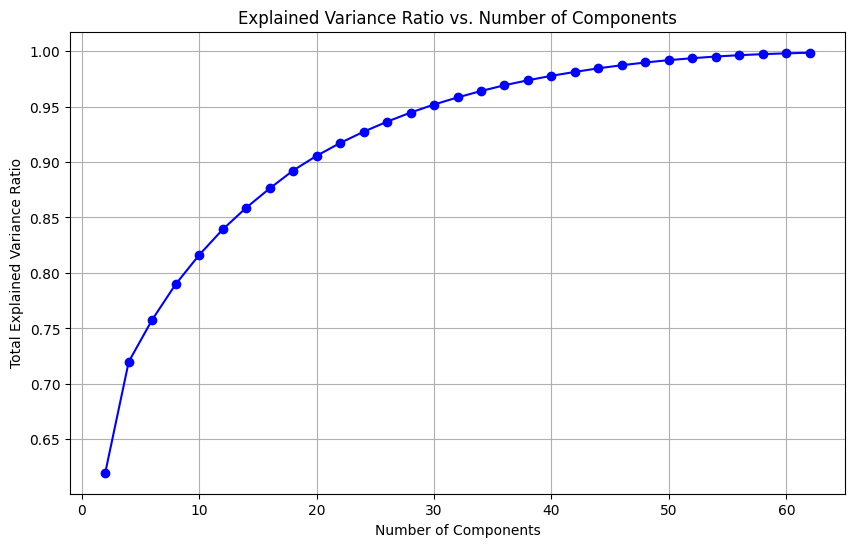

In [ ]:
# PCA
test_df = data_collect_f[2023]
test_df_nonnum = test_df[nonnum_columns]
test_df_numeric = test_df[numeric_columns]


def bestComponentValue(numeric_df):
    results = []
    for i in range(2, 64, 2):
        numData = numeric_df.loc[:, numeric_df.columns].values
        pca = PCA(n_components=i)
        pca.fit_transform(numData)
        variance_sum = pca.explained_variance_ratio_.sum()
        results.append((i, variance_sum))
        print(f'components = {i}, {variance_sum}')

    # Plotting the results
    components, explained_variance = zip(*results)
    plt.figure(figsize=(10, 6))
    plt.plot(components, explained_variance, marker='o', linestyle='-', color='b')

    plt.title('Explained Variance Ratio vs. Number of Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Total Explained Variance Ratio')
    plt.grid(True)
    plt.show()


bestComponentValue(test_df_numeric)

In [ ]:
def PCA_transform(df, n_components):
  pca = PCA(n_components=n_components)
  nonnum_columns = ["playerId", "name", "position", "season"]
  numeric_columns  = list(set(metrics_no_icetime) - set(nonnum_columns))
  df_nonnum = df[nonnum_columns]
  df_numeric = df[numeric_columns]
  trans_df = pca.fit_transform(df_numeric)
  new_df = pd.DataFrame(trans_df, index=df.index)
  new_df = pd.concat([df_nonnum.reset_index(drop=True),new_df.reset_index(drop=True)], axis=1)
  return new_df

In [ ]:
forwards = pd.concat(data_collect_f.values(), ignore_index=True)
defensemen = pd.concat(data_collect_d.values(), ignore_index=True)

In [ ]:
forwards.shape

(7976, 131)

In [ ]:
forwards_pca = PCA_transform(forwards, 30)

In [ ]:
forwards_pca.shape

(7976, 34)

In [ ]:
def find_nearest_neighbors(forwards, defensemen, player_name, season, position, num_neighbors=5, filter_season=None):
    """
    Finds the 5 nearest neighbors for a given player.

    Parameters:
    forwards (pd.DataFrame): DataFrame containing forward player stats.
    defensemen (pd.DataFrame): DataFrame containing defenseman player stats.
    player_name (str): Name of the player to search for.
    season (int): Season of the player to search for.
    position (str): Position of the player ('F' for forward, 'D' for defenseman).
    filter_season (int, optional): If provided, filters nearest neighbors by this season.

    Returns:
    pd.DataFrame: DataFrame of the 5 nearest neighbors' names and seasons.
    """
    # Validate position
    if position not in ['F', 'D']:
        raise ValueError("Position must be 'F' for forwards or 'D' for defensemen.")

    # Select the appropriate DataFrame
    if position == 'F':
        df = forwards
    else:
        df = defensemen

    # Filter for the correct season
    player_df = df[df['season'] == season]

    # Ensure the DataFrame contains the player
    if player_name not in player_df['name'].values:
        raise ValueError(f"Player {player_name} not found in the specified position and season dataset.")

    # If filter_season is provided, use only data from that season for neighbors
    if filter_season is not None:
        df = df[df['season'] == filter_season]

    # Separate features (stats) and player names, excluding the 'season' column
    features = df.drop(columns=["playerId", "name", "position", "season"], errors='ignore').values
    names = df[['name', 'season']].values

    # Fit the NearestNeighbors model
    model = NearestNeighbors(n_neighbors=num_neighbors+1, metric='euclidean')  # 6 to include the player itself
    model.fit(features)

    # Find the player's index in the player_df
    player_features = player_df.drop(columns=["playerId", "name", "position", "season"], errors='ignore').values
    player_names = player_df[['name', 'season']].values
    player_index = np.where((player_names[:, 0] == player_name) & (player_names[:, 1] == season))[0][0]

    # Get the nearest neighbors
    distances, indices = model.kneighbors([player_features[player_index]])

    # Exclude the player itself and return the top 5 neighbors
    nearest_neighbors = [names[i].tolist() for i in indices[0] if i != player_index][1:num_neighbors+1]

    # Convert the result to a DataFrame
    nearest_neighbors_df = pd.DataFrame(nearest_neighbors, columns=['name', 'season'])

    return nearest_neighbors_df

In [ ]:
pca_neighbors = []
pca_titles = []
for i in range(5, 50, 5):
  neighbors_pca = find_nearest_neighbors(PCA_transform(forwards, i), PCA_transform(defensemen, i), 'Auston Matthews', 2023, 'F', 10)
  pca_neighbors.append(neighbors_pca)
  pca_titles.append(f'{i} Components')

display_side_by_side(pca_neighbors, titles=pca_titles)

,name,season
0,Evgeni Malkin,2011
1,Alex Ovechkin,2019
2,Brady Tkachuk,2022
3,James Neal,2011
4,Auston Matthews,2020
5,Filip Forsberg,2023
6,Alex Ovechkin,2024
7,Jeff Carter,2010
8,Alex Ovechkin,2012
9,Auston Matthews,2022


In [ ]:
def find_nearest_neighbors(forwards, defensemen, player_name, season, position, num_neighbors=5, filter_season=None):
    """
    Finds the 5 nearest neighbors for a given player.

    Parameters:
    forwards (pd.DataFrame): DataFrame containing forward player stats.
    defensemen (pd.DataFrame): DataFrame containing defenseman player stats.
    player_name (str): Name of the player to search for.
    season (int): Season of the player to search for.
    position (str): Position of the player ('F' for forward, 'D' for defenseman).
    filter_season (int, optional): If provided, filters nearest neighbors by this season.

    Returns:
    pd.DataFrame: DataFrame of the 5 nearest neighbors' names and seasons.
    """
    # Validate position
    if position not in ['F', 'D']:
        raise ValueError("Position must be 'F' for forwards or 'D' for defensemen.")

    # Select the appropriate DataFrame
    if position == 'F':
        df = forwards
    else:
        df = defensemen

    # Filter for the correct season
    player_df = df[df['season'] == season]

    # Ensure the DataFrame contains the player
    if player_name not in player_df['name'].values:
        raise ValueError(f"Player {player_name} not found in the specified position and season dataset.")

    # If filter_season is provided, use only data from that season for neighbors
    if filter_season is not None:
        df = df[df['season'] == filter_season]

    # Exclude the player_name from the neighbors dataset
    df = df[df['name'] != player_name]

    # Separate features (stats) and player names, excluding the 'season' column
    features = df.drop(columns=["playerId", "name", "position", "season"], errors='ignore').values
    names = df[['name', 'season']].values

    # Fit the NearestNeighbors model
    model = NearestNeighbors(n_neighbors=num_neighbors + 1, metric='euclidean')
    model.fit(features)

    # Find the player's index in the player_df
    player_features = player_df.drop(columns=["playerId", "name", "position", "season"], errors='ignore').values
    player_names = player_df[['name', 'season']].values
    player_index = np.where((player_names[:, 0] == player_name) & (player_names[:, 1] == season))[0][0]

    # Get the nearest neighbors
    distances, indices = model.kneighbors([player_features[player_index]])

    # Filter neighbors to exclude any matching the player_name and return the top 5
    nearest_neighbors = [
        names[i].tolist()
        for i in indices[0]
        if names[i][0] != player_name
    ][:num_neighbors]

    # Convert the result to a DataFrame
    nearest_neighbors_df = pd.DataFrame(nearest_neighbors, columns=['name', 'season'])

    return nearest_neighbors_df


In [ ]:
pca_neighbors = []
pca_titles = []
for i in range(5, 50, 5):
  neighbors_pca = find_nearest_neighbors(PCA_transform(forwards, i), PCA_transform(defensemen, i), 'Auston Matthews', 2023, 'F', 10)
  pca_neighbors.append(neighbors_pca)
  pca_titles.append(f'{i} Components')

display_side_by_side(pca_neighbors, titles=pca_titles)

,name,season
0,Evgeni Malkin,2011
1,Alex Ovechkin,2019
2,Brady Tkachuk,2022
3,James Neal,2011
4,Filip Forsberg,2023
5,Alex Ovechkin,2024
6,Jeff Carter,2010
7,Alex Ovechkin,2012
8,David Pastrnak,2019
9,Steven Stamkos,2016


In [ ]:
# Row-wise percentage

def convert_to_row_percentages(df):
    """
    Convert a DataFrame's stat values to row-wise percentages.
    Drops non-stat columns before calculating percentages and adds them back.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing ['playerId', 'name', 'position', 'season'] and stat columns.

    Returns:
        pd.DataFrame: A DataFrame with stat values converted to row-wise percentages.
    """
    # Identify non-stat columns to exclude during percentage calculation
    non_stat_columns = ['playerId', 'name', 'position', 'season']

    # Separate non-stat and stat data
    non_stat_data = df[non_stat_columns]
    stat_data = df.drop(columns=non_stat_columns, errors='ignore')

    # Convert stat columns to row-wise percentages
    stat_percentages = stat_data.div(stat_data.sum(axis=1), axis=0) * 100

    # Combine non-stat data with the percentage stats
    result_df = pd.concat([non_stat_data, stat_percentages], axis=1)

    return result_df

In [ ]:
forwards_with_row_percentages = convert_to_row_percentages(forwards)
defensemen_with_row_percentages = convert_to_row_percentages(defensemen)

In [ ]:
pca_neighbors = []
pca_titles = []
for i in range(5, 50, 5):
  neighbors_pca = find_nearest_neighbors(PCA_transform(forwards_with_row_percentages, i), PCA_transform(defensemen_with_row_percentages, i), 'Auston Matthews', 2023, 'F', 10)
  pca_neighbors.append(neighbors_pca)
  pca_titles.append(f'{i} Components')

display_side_by_side(pca_neighbors, titles=pca_titles)

,name,season
0,Alex Ovechkin,2019
1,Brady Tkachuk,2022
2,Filip Forsberg,2023
3,Nathan MacKinnon,2018
4,Taylor Hall,2016
5,Evgeni Malkin,2011
6,Jonathan Marchessault,2018
7,James Neal,2011
8,Max Pacioretty,2014
9,Kirill Kaprizov,2022


In [ ]:
def least_inter_correlated_columns(df, n):
    """
    Selects the n least inter-correlated numeric columns from a DataFrame.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing numeric columns.
        n (int): Number of columns to select.

    Returns:
        tuple: A tuple containing two DataFrames:
            - A DataFrame with the n columns having the least average correlation coefficients.
            - A DataFrame with the n columns having the least maximum correlation coefficients to another variable.
    """
    # Compute the correlation matrix
    correlation_matrix = df.corr().abs()

    # Set diagonal to infinity to exclude self-correlation
    np.fill_diagonal(correlation_matrix.values, np.inf)

    # Calculate average correlation for each column
    avg_correlation = correlation_matrix.replace(np.inf, 0).mean(axis=0)

    # Calculate maximum correlation for each column
    max_correlation = correlation_matrix.replace(np.inf, 0).max(axis=0)

    # Select the n columns with the lowest average correlation
    avg_selected_columns = avg_correlation.nsmallest(n).index
    avg_result_df = pd.DataFrame({
        'Feature': avg_selected_columns,
        'Average Correlation': avg_correlation[avg_selected_columns].values
    }).reset_index(drop=True)

    # Select the n columns with the lowest maximum correlation
    max_selected_columns = max_correlation.nsmallest(n).index
    max_result_df = pd.DataFrame({
        'Feature': max_selected_columns,
        'Maximum Correlation': max_correlation[max_selected_columns].values
    }).reset_index(drop=True)

    return avg_result_df, max_result_df

In [ ]:
nonnum_columns = ["playerId", "name", "position", "season"]
numeric_columns  = list(set(metrics_no_icetime) - set(nonnum_columns))
forwards_nonnum = forwards[nonnum_columns]
forwards_numeric = forwards[numeric_columns]

defensemen_nonnum = defensemen[nonnum_columns]
defensemen_numeric = defensemen[numeric_columns]

least_inter_correlated, least_max_correlated = least_inter_correlated_columns(pd.concat([forwards_numeric, defensemen_numeric], axis=0), 30)

display_side_by_side([least_inter_correlated, least_max_correlated], ['Least Average Correlation Features', 'Least Maximum Correlation Features'])

,Feature,Average Correlation
0,bmi,0.042142
1,height,0.052227
2,weight,0.066464
3,age,0.072160
4,I_F_dZoneGiveaways,0.078433
5,I_F_faceOffsWon,0.079768
6,I_F_neutralZoneShiftStarts,0.107294
7,OnIce_A_mediumDangerGoals,0.123548
8,OnIce_A_lowDangerGoals,0.135491
9,I_F_giveaways,0.142016


In [ ]:
def reduce_dataframe(original_df, selected_columns_df):
    """
    Reduces the input DataFrame to include only the essential columns based on selected features.

    Parameters:
        original_df (pd.DataFrame): The original DataFrame with all columns.
        selected_columns_df (pd.DataFrame): A DataFrame containing selected column names in a 'Feature' column.

    Returns:
        pd.DataFrame: A reduced DataFrame with ['playerId', 'name', 'position', 'season'] plus selected columns.
    """
    # Columns to always keep
    essential_columns = ['playerId', 'name', 'position', 'season']

    # Extract the selected feature names
    selected_columns = selected_columns_df['Feature'].tolist()

    # Ensure all necessary columns are present in the final DataFrame
    reduced_df = original_df[essential_columns + selected_columns]

    return reduced_df

In [ ]:
neighbors_least_inter = find_nearest_neighbors(reduce_dataframe(forwards, least_inter_correlated), reduce_dataframe(defensemen, least_inter_correlated), 'Auston Matthews', 2023, 'F', 10)

neighbors_least_max = find_nearest_neighbors(reduce_dataframe(forwards, least_max_correlated), reduce_dataframe(defensemen, least_max_correlated), 'Auston Matthews', 2023, 'F', 10)

display_side_by_side([neighbors_least_inter, neighbors_least_max], ['Auston Matthews KNN w/ Least Avg Correlation Features', 'Auston Matthews KNN w/ Least Maximum Correlation Features'])

,name,season
0,Ryan O'Reilly,2020
1,Leon Draisaitl,2023
2,Casey Mittelstadt,2023
3,Jack Eichel,2023
4,Brock Nelson,2022
5,Connor McDavid,2022
6,Mika Zibanejad,2023
7,Mika Zibanejad,2022
8,Anze Kopitar,2017
9,Nick Suzuki,2023


In [ ]:
def least_avg_correlated_columns(df, n):
    # Compute the correlation matrix
    correlation_matrix = df.corr().abs()

    # Set diagonal to infinity to exclude self-correlation
    np.fill_diagonal(correlation_matrix.values, np.inf)

    # Calculate average correlation for each column
    avg_correlation = correlation_matrix.replace(np.inf, 0).mean(axis=0)

    # Select the n columns with the lowest average correlation
    avg_selected_columns = avg_correlation.nsmallest(n).index
    avg_result_df = pd.DataFrame({
        'Feature': avg_selected_columns,
        'Average Correlation': avg_correlation[avg_selected_columns].values
    }).reset_index(drop=True)


    return avg_result_df

def least_max_correlated_columns(df, n):

    # Compute the correlation matrix
    correlation_matrix = df.corr().abs()

    # Set diagonal to infinity to exclude self-correlation
    np.fill_diagonal(correlation_matrix.values, np.inf)

    # Calculate maximum correlation for each column
    max_correlation = correlation_matrix.replace(np.inf, 0).max(axis=0)

    # Select the n columns with the lowest maximum correlation
    max_selected_columns = max_correlation.nsmallest(n).index
    max_result_df = pd.DataFrame({
        'Feature': max_selected_columns,
        'Maximum Correlation': max_correlation[max_selected_columns].values
    }).reset_index(drop=True)

    return max_result_df

In [ ]:
least_avg_neighbors = []
least_avg_titles = []
for i in range(5, 50, 5):
  cols = least_avg_correlated_columns(forwards_numeric, i)
  neighbors = find_nearest_neighbors(reduce_dataframe(forwards, cols), reduce_dataframe(defensemen, cols), 'George Parros', 2010, 'F', 10)
  least_avg_neighbors.append(neighbors)
  least_avg_titles.append(f'{i} features')

display_side_by_side(least_avg_neighbors, titles=least_avg_titles)

,name,season
0,Dainius Zubrus,2008
1,Troy Brouwer,2015
2,Jujhar Khaira,2022
3,Alex Chiasson,2021
4,Patrik Berglund,2018
5,Joel Armia,2022
6,Mark Jankowski,2022
7,Valeri Nichushkin,2023
8,David Backes,2015
9,Valeri Nichushkin,2022


In [ ]:
least_avg_neighbors = []
least_avg_titles = []
for i in range(5, 50, 5):
  cols = least_avg_correlated_columns(defensemen_numeric, i)
  neighbors = find_nearest_neighbors(reduce_dataframe(forwards, cols), reduce_dataframe(defensemen, cols), 'Erik Karlsson', 2014, 'D', 10)
  least_avg_neighbors.append(neighbors)
  least_avg_titles.append(f'{i} features')

display_side_by_side(least_avg_neighbors, titles=least_avg_titles)

,name,season
0,Jake Gardiner,2014
1,Tim Heed,2017
2,Oliver Kylington,2023
3,Tony DeAngelo,2019
4,Brent Burns,2011
5,Jason Demers,2013
6,Matt Taormina,2010
7,Thomas Chabot,2023
8,Oliver Kylington,2021
9,Mike Matheson,2017


In [ ]:
least_max_neighbors = []
least_max_titles = []
for i in range(5, 50, 5):
  cols = least_max_correlated_columns(forwards_numeric, i)
  neighbors = find_nearest_neighbors(reduce_dataframe(forwards, cols), reduce_dataframe(defensemen, cols), 'George Parros', 2010, 'F', 10)
  least_max_neighbors.append(neighbors)
  least_max_titles.append(f'{i} features')

display_side_by_side(least_max_neighbors, titles=least_max_titles)

,name,season
0,Luke Glendening,2021
1,Jesper Fast,2021
2,Blair Betts,2009
3,Aaron Voros,2009
4,Kyle Clifford,2020
5,Alex Killorn,2018
6,Nicolas Deslauriers,2020
7,Samuel Pahlsson,2010
8,Garnet Hathaway,2021
9,Casey Cizikas,2020


In [ ]:
least_max_neighbors = []
least_max_titles = []
for i in range(5, 50, 5):
  cols = least_max_correlated_columns(forwards_numeric, i)
  neighbors = find_nearest_neighbors(reduce_dataframe(forwards, cols), reduce_dataframe(defensemen, cols), 'Erik Karlsson', 2014, 'D', 10)
  least_max_neighbors.append(neighbors)
  least_max_titles.append(f'{i} features')

display_side_by_side(least_max_neighbors, titles=least_max_titles)

,name,season
0,Dylan Reese,2009
1,Nick Perbix,2022
2,Shea Weber,2010
3,Dustin Byfuglien,2009
4,Matt Hunwick,2011
5,Ian White,2008
6,Colin Miller,2016
7,Cale Makar,2022
8,Travis Hamonic,2011
9,Isaak Phillips,2023


In [ ]:
from sklearn.decomposition import NMF, FastICA

def reduce_with_nmf(df, n_components):
    """
    Reduces the DataFrame using Non-negative Matrix Factorization (NMF).

    Parameters:
        df (pd.DataFrame): Input DataFrame with columns ['playerId', 'name', 'position', 'season'] and numeric stats.
        n_components (int): Number of components for NMF.

    Returns:
        pd.DataFrame: Transformed DataFrame with ['playerId', 'name', 'position', 'season'] plus reduced dimensions.
    """
    # Split metadata and numeric columns
    nonnum_df = df[['playerId', 'name', 'position', 'season']]
    numeric_df = df.drop(columns=['playerId', 'name', 'position', 'season'])

    # Shift data to be non-negative
    min_value = numeric_df.min().min()
    if min_value < 0:
        numeric_df += abs(min_value)

    nmf = NMF(n_components=n_components, random_state=42)
    reduced = nmf.fit_transform(numeric_df)

    reduced_df = pd.DataFrame(reduced, columns=[f'NMF_Component_{i+1}' for i in range(n_components)])
    return pd.concat([nonnum_df, reduced_df], axis=1)


def reduce_with_ica(df, n_components):
    """
    Reduces the DataFrame using Independent Component Analysis (ICA).

    Parameters:
        df (pd.DataFrame): Input DataFrame with columns ['playerId', 'name', 'position', 'season'] and numeric stats.
        n_components (int): Number of components for ICA.

    Returns:
        pd.DataFrame: Transformed DataFrame with ['playerId', 'name', 'position', 'season'] plus reduced dimensions.
    """
    # Split metadata and numeric columns
    nonnum_df = df[['playerId', 'name', 'position', 'season']]
    numeric_df = df.drop(columns=['playerId', 'name', 'position', 'season'])

    ica = FastICA(n_components=n_components, random_state=42)
    reduced = ica.fit_transform(numeric_df)

    reduced_df = pd.DataFrame(reduced, columns=[f'ICA_Component_{i+1}' for i in range(n_components)])
    return pd.concat([nonnum_df, reduced_df], axis=1)

In [ ]:
least_nmf_neighbors = []
least_nmf_titles = []
for i in range(5, 50, 5):
  neighbors = find_nearest_neighbors(reduce_with_nmf(forwards, i), reduce_with_nmf(defensemen, i), 'Erik Karlsson', 2014, 'D', 10)
  least_nmf_neighbors.append(neighbors)
  least_nmf_titles.append(f'{i} features')

display_side_by_side(least_nmf_neighbors, titles=least_nmf_titles)

,name,season
0,Shea Theodore,2019
1,Brent Burns,2017
2,Brent Burns,2022
3,Roman Josi,2019
4,Quinn Hughes,2024
5,Shea Weber,2009
6,Brent Burns,2018
7,Shea Theodore,2020
8,Torey Krug,2014
9,Shea Weber,2008


In [ ]:
least_ica_neighbors = []
least_ica_titles = []
for i in range(5, 50, 5):
  neighbors = find_nearest_neighbors(reduce_with_ica(forwards, i), reduce_with_ica(defensemen, i), 'Erik Karlsson', 2014, 'D', 10)
  least_ica_neighbors.append(neighbors)
  least_ica_titles.append(f'{i} features')

display_side_by_side(least_ica_neighbors, titles=least_ica_titles)

,name,season
0,Brent Burns,2022
1,Brent Burns,2018
2,Quinn Hughes,2024
3,Noah Dobson,2022
4,Brent Burns,2017
5,Shea Theodore,2020
6,Dougie Hamilton,2022
7,Roman Josi,2019
8,Dougie Hamilton,2020
9,Shea Weber,2009


In [ ]:
least_nmf_neighbors = []
least_nmf_titles = []
for i in range(5, 50, 5):
  neighbors = find_nearest_neighbors(reduce_with_nmf(forwards, i), reduce_with_nmf(defensemen, i), 'Joe Thornton', 2013, 'F', 10)
  least_nmf_neighbors.append(neighbors)
  least_nmf_titles.append(f'{i} features')

display_side_by_side(least_nmf_neighbors, titles=least_nmf_titles)

,name,season
0,Henrik Sedin,2010
1,Mike Ribeiro,2014
2,Nicklas Backstrom,2014
3,Henrik Sedin,2013
4,Nicklas Backstrom,2019
5,Mathew Barzal,2017
6,Nicklas Backstrom,2008
7,Henrik Sedin,2012
8,Ryan Getzlaf,2010
9,Jonathan Drouin,2023


In [ ]:
least_ica_neighbors = []
least_ica_titles = []
for i in range(5, 50, 5):
  neighbors = find_nearest_neighbors(reduce_with_ica(forwards, i), reduce_with_ica(defensemen, i), 'Joe Thornton', 2013, 'F', 10)
  least_ica_neighbors.append(neighbors)
  least_ica_titles.append(f'{i} features')

display_side_by_side(least_ica_neighbors, titles=least_ica_titles)

,name,season
0,Mike Ribeiro,2016
1,Nicklas Backstrom,2008
2,Henrik Sedin,2017
3,Nicklas Backstrom,2019
4,Mike Ribeiro,2013
5,Ryan Johansen,2018
6,Henrik Sedin,2010
7,Mike Ribeiro,2015
8,Michael Nylander,2008
9,Ryan Johansen,2017


### Final Results (with 2016 Brent Burns)

In [ ]:
neighbors = []
titles = []
for i in range(5, 50, 5):
  result = find_nearest_neighbors(PCA_transform(forwards, i), PCA_transform(defensemen, i), 'Brent Burns', 2016, 'D', 5)
  neighbors.append(result)
  titles.append(f'{i} Features')

display_side_by_side(neighbors, titles=titles)

,name,season
0,Roman Josi,2022
1,Dustin Byfuglien,2011
2,Roman Josi,2024
3,Dustin Byfuglien,2010
4,John Carlson,2022
,name,season
0,Dustin Byfuglien,2011
1,Dougie Hamilton,2021
2,Roman Josi,2022
3,Dustin Byfuglien,2010


In [ ]:
burns_perc_n = find_nearest_neighbors(forwards_with_row_percentages, defensemen_with_row_percentages, 'Brent Burns', 2016, 'D')
burns_perc_n

,name,season
0,Dustin Byfuglien,2011
1,Roman Josi,2022
2,Roman Josi,2018
3,Dougie Hamilton,2021
4,Dustin Byfuglien,2015


In [ ]:
neighbors = []
titles = []
for i in range(5, 50, 5):
  result = find_nearest_neighbors(PCA_transform(forwards_with_row_percentages, i), PCA_transform(defensemen_with_row_percentages, i), 'Brent Burns', 2016, 'D', 5)
  neighbors.append(result)
  titles.append(f'{i} Features')

display_side_by_side(neighbors, titles=titles)

,name,season
0,Jakob Chychrun,2022
1,Roman Josi,2024
2,Roman Josi,2022
3,Zach Werenski,2024
4,Dustin Byfuglien,2011
,name,season
0,Dustin Byfuglien,2011
1,Erik Karlsson,2016
2,Dougie Hamilton,2021
3,Jakob Chychrun,2022


In [ ]:
least_avg_neighbors = []
least_avg_titles = []
for i in range(5, 50, 5):
  cols = least_avg_correlated_columns(defensemen_numeric, i)
  neighbors = find_nearest_neighbors(reduce_dataframe(forwards, cols), reduce_dataframe(defensemen, cols), 'Brent Burns', 2016, 'D', 5)
  least_avg_neighbors.append(neighbors)
  least_avg_titles.append(f'{i} features')

display_side_by_side(least_avg_neighbors, titles=least_avg_titles)

,name,season
0,Jonathan Ericsson,2019
1,Josh Manson,2024
2,John Erskine,2012
3,Scott Mayfield,2023
4,Erik Gustafsson,2024
,name,season
0,Jonathan Ericsson,2019
1,John Erskine,2012
2,Joel Edmundson,2023
3,Scott Mayfield,2023


In [ ]:
least_max_neighbors = []
least_max_titles = []
for i in range(5, 50, 5):
  cols = least_max_correlated_columns(forwards_numeric, i)
  neighbors = find_nearest_neighbors(reduce_dataframe(forwards, cols), reduce_dataframe(defensemen, cols), 'Brent Burns', 2016, 'D', 5)
  least_max_neighbors.append(neighbors)
  least_max_titles.append(f'{i} features')

display_side_by_side(least_max_neighbors, titles=least_max_titles)

,name,season
0,Mark Giordano,2014
1,Mark Giordano,2017
2,Jeff Petry,2017
3,Dennis Wideman,2014
4,Alex Pietrangelo,2019
,name,season
0,Alex Pietrangelo,2019
1,Victor Hedman,2022
2,Dennis Wideman,2014
3,Kris Letang,2014


In [ ]:
least_nmf_neighbors = []
least_nmf_titles = []
for i in range(5, 50, 5):
  neighbors = find_nearest_neighbors(reduce_with_nmf(forwards, i), reduce_with_nmf(defensemen, i), 'Brent Burns', 2016, 'D', 5)
  least_nmf_neighbors.append(neighbors)
  least_nmf_titles.append(f'{i} features')

display_side_by_side(least_nmf_neighbors, titles=least_nmf_titles)

,name,season
0,Roman Josi,2022
1,Zach Werenski,2024
2,Dougie Hamilton,2019
3,Roman Josi,2024
4,Roman Josi,2021
,name,season
0,Dustin Byfuglien,2011
1,Zach Werenski,2024
2,Dougie Hamilton,2019
3,Roman Josi,2021


In [ ]:
least_ica_neighbors = []
least_ica_titles = []
for i in range(5, 50, 5):
  neighbors = find_nearest_neighbors(reduce_with_ica(forwards, i), reduce_with_ica(defensemen, i), 'Brent Burns', 2016, 'D', 5)
  least_ica_neighbors.append(neighbors)
  least_ica_titles.append(f'{i} features')

display_side_by_side(least_ica_neighbors, titles=least_ica_titles)

,name,season
0,Roman Josi,2024
1,Roman Josi,2022
2,Dustin Byfuglien,2011
3,Dustin Byfuglien,2010
4,Dougie Hamilton,2019
,name,season
0,Dustin Byfuglien,2011
1,John Carlson,2016
2,Erik Karlsson,2011
3,Darnell Nurse,2016


### Testing Scalers for Preprocessing

In [ ]:
def normalize_columns_minmax(df):
    # Columns to exclude from normalization
    exclude_cols = ["playerId", "name", "position", "season", "icetime"]

    # Create a copy to avoid modifying the original DataFrame
    df_normalized = df.copy()

    # Identify columns to normalize
    cols_to_normalize = [col for col in df.columns if col not in exclude_cols]

    # Iterate over columns and apply MinMaxScaler
    for col in cols_to_normalize:
        # Check if the column is numeric
        if pd.api.types.is_numeric_dtype(df_normalized[col]):
            scaler = MinMaxScaler()
            df_normalized[col] = scaler.fit_transform(df_normalized[[col]])
    return df_normalized

def normalize_columns_standard(df):
    # Columns to exclude from normalization
    exclude_cols = ["playerId", "name", "position", "season", "icetime"]

    # Create a copy to avoid modifying the original DataFrame
    df_normalized = df.copy()

    # Identify columns to normalize
    cols_to_normalize = [col for col in df.columns if col not in exclude_cols]

    # Iterate over columns and apply MinMaxScaler
    for col in cols_to_normalize:
        # Check if the column is numeric
        if pd.api.types.is_numeric_dtype(df_normalized[col]):
            scaler = StandardScaler()
            df_normalized[col] = scaler.fit_transform(df_normalized[[col]])
    return df_normalized

def normalize_columns_robust(df):
    # Columns to exclude from normalization
    exclude_cols = ["playerId", "name", "position", "season", "icetime"]

    # Create a copy to avoid modifying the original DataFrame
    df_normalized = df.copy()

        # Identify columns to normalize
    cols_to_normalize = [col for col in df.columns if col not in exclude_cols]

    # Iterate over columns and apply MinMaxScaler
    for col in cols_to_normalize:
        # Check if the column is numeric
        if pd.api.types.is_numeric_dtype(df_normalized[col]):
            scaler = RobustScaler()
            df_normalized[col] = scaler.fit_transform(df_normalized[[col]])
    return df_normalized

def normalize_columns_maxabs(df):
    # Columns to exclude from normalization
    exclude_cols = ["playerId", "name", "position", "season", "icetime"]

    # Create a copy to avoid modifying the original DataFrame
    df_normalized = df.copy()

        # Identify columns to normalize
    cols_to_normalize = [col for col in df.columns if col not in exclude_cols]

    # Iterate over columns and apply MinMaxScaler
    for col in cols_to_normalize:
        # Check if the column is numeric
        if pd.api.types.is_numeric_dtype(df_normalized[col]):
            scaler = MaxAbsScaler()
            df_normalized[col] = scaler.fit_transform(df_normalized[[col]])
    return df_normalized


In [ ]:
def find_nearest_neighbors_with_attributes(forwards, defensemen, player_name, season, position, num_neighbors=5, filter_season=None):
    # Validate position
    if position not in ['F', 'D']:
        raise ValueError("Position must be 'F' for forwards or 'D' for defensemen.")

    # Select the appropriate DataFrame
    if position == 'F':
        df = forwards
    else:
        df = defensemen

    # Filter for the correct season
    player_df = df[df['season'] == season]

    # Ensure the DataFrame contains the player
    if player_name not in player_df['name'].values:
        raise ValueError(f"Player {player_name} not found in the specified position and season dataset.")

    # If filter_season is provided, use only data from that season for neighbors
    if filter_season is not None:
        df = df[df['season'] == filter_season]

    # Exclude the player_name from the neighbors dataset
    df = df[df['name'] != player_name]

    # Separate features (stats) and player names, excluding the 'season' column
    features = df.drop(columns=["playerId", "name", "position", "season", "I_F_faceOffsWon"], errors='ignore')
    names = df[['name', 'season']]

    # Fit the NearestNeighbors model
    model = NearestNeighbors(n_neighbors=num_neighbors + 1, metric='euclidean')
    model.fit(features)

    # Find the playera's index in the player_df, drop I_F_faceOffsWon since we're testing with defensemen
    player_features = player_df.drop(columns=["playerId", "name", "position", "season", "I_F_faceOffsWon"], errors='ignore').values
    player_names = player_df[['name', 'season']].values
    player_index = np.where((player_names[:, 0] == player_name) & (player_names[:, 1] == season))[0][0]

    # Get the nearest neighbors
    distances, indices = model.kneighbors([player_features[player_index]])

    # Prepare results
    nearest_neighbors = []
    for i in indices[0]:
        if names.iloc[i]['name'] != player_name:
            neighbor_name = names.iloc[i]['name']
            neighbor_season = names.iloc[i]['season']
            neighbor_features = features.iloc[i]

            # Calculate attribute differences
            differences = abs(player_features[player_index] - neighbor_features)
            top_attributes = differences.nsmallest(5).index.tolist()

            neighbor_data = {
                'name': neighbor_name,
                'season': neighbor_season
            }

            # Add top attributes as separate columns
            for j, attribute in enumerate(top_attributes):
                neighbor_data[f'top_attribute_{j+1}'] = attribute

            nearest_neighbors.append(neighbor_data)

            if len(nearest_neighbors) == num_neighbors:
                break

    return pd.DataFrame(nearest_neighbors)


In [ ]:
def display_dataframes_vertically(dataframes, titles):
    """
    Displays a list of dataframes vertically with titles.

    Parameters:
    dataframes (list of pd.DataFrame): List of dataframes to display.
    titles (list of str): List of titles corresponding to the dataframes.
    """
    if len(dataframes) != len(titles):
        raise ValueError("The number of dataframes and titles must match.")

    for df, title in zip(dataframes, titles):
        display(Markdown(f"## {title}"))  # Display title as a heading
        display(df)  # Display the DataFrame

In [ ]:
minmax_d = {}
minmax_f = {}
standard_d = {}
standard_f = {}
robust_d = {}
robust_f = {}
max_abs_d = {}
max_abs_f = {}

results = []
result_titles = ['MinMax', 'Standard', 'Robust', 'MaxAbs']

for year in range(2008, 2025):
  data_d = unmodded_data_d[year]
  data_f = unmodded_data_f[year]
  data_d = process_data(data_d)
  data_f = process_data(data_f)
  data_d = impute_data(data_d)
  data_f = impute_data(data_f)
  data_d = add_bmi(data_d)
  data_f = add_bmi(data_f)
  data_d = scale_stats_per_60_min(data_d)
  data_f = scale_stats_per_60_min(data_f)
  minmax_d[year]= normalize_columns_minmax(data_d)
  minmax_f[year] = normalize_columns_minmax(data_f)
  standard_d[year] = normalize_columns_standard(data_d)
  standard_f[year] = normalize_columns_standard(data_f)
  robust_d[year] = normalize_columns_robust(data_d)
  robust_f[year] = normalize_columns_robust(data_f)
  max_abs_d[year] = normalize_columns_maxabs(data_d)
  max_abs_f[year] = normalize_columns_maxabs(data_f)

minmax_forwards = pd.concat(minmax_f.values(), ignore_index=True)
minmax_defensemen = pd.concat(minmax_d.values(), ignore_index=True)
standard_forwards = pd.concat(standard_f.values(), ignore_index=True)
standard_defensemen = pd.concat(standard_d.values(), ignore_index=True)
robust_forwards = pd.concat(robust_f.values(), ignore_index=True)
robust_defensemen = pd.concat(robust_d.values(), ignore_index=True)
max_abs_forwards = pd.concat(max_abs_f.values(), ignore_index=True)
max_abs_defensemen = pd.concat(max_abs_d.values(), ignore_index=True)

results.append(find_nearest_neighbors_with_attributes(minmax_forwards, minmax_defensemen, 'Brent Burns', 2016, 'D', 10))
results.append(find_nearest_neighbors_with_attributes(standard_forwards, standard_defensemen, 'Brent Burns', 2016, 'D', 10))
results.append(find_nearest_neighbors_with_attributes(robust_forwards, robust_defensemen, 'Brent Burns', 2016, 'D', 10))
results.append(find_nearest_neighbors_with_attributes(max_abs_forwards, max_abs_defensemen, 'Brent Burns', 2016, 'D', 10))

display_dataframes_vertically(results, result_titles)

## MinMax

,name,season,top_attribute_1,top_attribute_2,top_attribute_3,top_attribute_4,top_attribute_5
0,Dustin Byfuglien,2011,I_F_mediumDangerShots,I_F_playContinuedOutsideZone,I_F_missedShots,I_F_xFreeze,I_F_xPlayContinuedInZone
1,Roman Josi,2022,I_F_mediumDangerShots,I_F_unblockedShotAttempts,I_F_xPlayContinuedInZone,I_F_xRebounds,I_F_shotsOnGoal
2,Dougie Hamilton,2021,I_F_xFreeze,I_F_unblockedShotAttempts,I_F_xRebounds,I_F_shotsOnGoal,I_F_savedUnblockedShotAttempts
3,Erik Karlsson,2011,OnIce_F_blockedShotAttempts,I_F_blockedShotAttempts,OnIce_F_missedShots,I_F_highDangerxGoals,I_F_flyShiftEnds
4,Dustin Byfuglien,2010,I_F_mediumDangerShots,I_F_missedShots,I_F_xFreeze,I_F_unblockedShotAttempts,I_F_mediumDangerxGoals
5,Dougie Hamilton,2019,I_F_mediumDangerShots,I_F_scoreAdjustedShotsAttempts,I_F_xPlayContinuedInZone,I_F_xRebounds,I_F_shotAttempts
6,Dustin Byfuglien,2015,I_F_mediumDangerShots,I_F_mediumDangerxGoals,height,I_F_flyShiftStarts,OnIce_F_reboundGoals
7,Zach Werenski,2024,I_F_mediumDangerShots,I_F_mediumDangerxGoals,I_F_xRebounds,I_F_xPlayContinuedOutsideZone,I_F_xOnGoal
8,Dustin Byfuglien,2014,I_F_mediumDangerShots,I_F_goals,I_F_mediumDangerxGoals,height,I_F_xRebounds
9,Roman Josi,2024,OnIce_F_xGoals_with_earned_rebounds,I_F_flurryAdjustedxGoals,OffIce_A_xGoals,OnIce_F_highDangerxGoals,I_F_flurryScoreVenueAdjustedxGoals


## Standard

,name,season,top_attribute_1,top_attribute_2,top_attribute_3,top_attribute_4,top_attribute_5
0,Dustin Byfuglien,2011,OnIce_F_lowDangerxGoals,height,OnIce_F_goals,I_F_flurryScoreVenueAdjustedxGoals,I_F_xPlayContinuedOutsideZone
1,Dougie Hamilton,2022,OnIce_F_mediumDangerxGoals,I_F_neutralZoneShiftEnds,OnIce_F_mediumDangerShots,I_F_hits,OnIce_F_flurryAdjustedxGoals
2,Dougie Hamilton,2021,I_F_mediumDangerShots,I_F_highDangerxGoals,OnIce_A_scoreAdjustedShotsAttempts,OnIce_A_lowDangerxGoals,OnIce_A_unblockedShotAttempts
3,Roman Josi,2022,OnIce_A_mediumDangerShots,OffIce_F_shotAttempts,OnIce_A_goals,OnIce_A_shotAttempts,OnIce_A_reboundGoals
4,Erik Karlsson,2011,I_F_dZoneShiftStarts,I_F_freeze,OnIce_F_shotAttempts,I_F_penalityMinutes,OffIce_F_xGoals
5,Mike Green,2008,I_F_xGoals_with_earned_rebounds_scoreFlurryAdj...,OnIce_A_lowDangerGoals,OnIce_A_lowDangerShots,I_F_freeze,OnIce_A_rebounds
6,Dougie Hamilton,2019,OnIce_F_xGoalsFromxReboundsOfShots,I_F_savedShotsOnGoal,I_F_flyShiftStarts,OffIce_A_shotAttempts,I_F_dZoneShiftEnds
7,Dougie Hamilton,2018,I_F_freeze,OnIce_F_flurryScoreVenueAdjustedxGoals,I_F_xPlayContinuedOutsideZone,OnIce_F_flurryAdjustedxGoals,I_F_highDangerxGoals
8,Roman Josi,2023,OnIce_F_unblockedShotAttempts,OffIce_F_xGoals,OnIce_A_shotsOnGoal,OffIce_A_shotAttempts,OnIce_F_mediumDangerxGoals
9,Roman Josi,2021,I_F_shifts,OnIce_F_xGoals,OffIce_F_xGoals,I_F_hits,age


## Robust

,name,season,top_attribute_1,top_attribute_2,top_attribute_3,top_attribute_4,top_attribute_5
0,Dougie Hamilton,2022,I_F_primaryAssists,OnIce_F_shotAttempts,I_F_hits,OnIce_A_goals,OnIce_F_mediumDangerxGoals
1,Dustin Byfuglien,2011,height,OnIce_F_unblockedShotAttempts,OnIce_F_xGoals,OnIce_A_xOnGoal,OnIce_A_scoreAdjustedUnblockedShotAttempts
2,Dougie Hamilton,2021,I_F_highDangerxGoals,OnIce_A_unblockedShotAttempts,OnIce_A_xOnGoal,OnIce_F_shotsOnGoal,OnIce_F_highDangerGoals
3,Erik Karlsson,2011,I_F_neutralZoneShiftEnds,OnIce_F_xGoals_with_earned_rebounds_scoreFlurr...,OffIce_F_xGoals,OnIce_F_xGoals_with_earned_rebounds,OnIce_F_xGoalsFromxReboundsOfShots
4,Roman Josi,2022,age,OnIce_A_xGoals,I_F_penalityMinutes,OnIce_A_shotAttempts,OnIce_A_reboundxGoals
5,Mike Green,2008,I_F_lowDangerGoals,OnIce_A_reboundGoals,OnIce_A_shotsOnGoal,OnIce_A_xOnGoal,OnIce_A_rebounds
6,Dougie Hamilton,2017,OnIce_F_shotAttempts,OnIce_F_xGoals_with_earned_rebounds,OnIce_F_flurryScoreVenueAdjustedxGoals,OnIce_F_xGoals_with_earned_rebounds_scoreFlurr...,I_F_highDangerGoals
7,Dougie Hamilton,2018,OnIce_F_highDangerxGoals,I_F_xRebounds,I_F_highDangerxGoals,I_F_xPlayStopped,I_F_highDangerGoals
8,Dougie Hamilton,2019,I_F_playStopped,I_F_dZoneShiftEnds,OffIce_A_shotAttempts,I_F_flyShiftStarts,I_F_xGoalsFromActualReboundsOfShots
9,Dustin Byfuglien,2010,height,OnIce_A_reboundGoals,I_F_dZoneShiftStarts,OffIce_F_xGoals,OnIce_F_lowDangerGoals


## MaxAbs

,name,season,top_attribute_1,top_attribute_2,top_attribute_3,top_attribute_4,top_attribute_5
0,Dustin Byfuglien,2011,I_F_scoreAdjustedUnblockedShotAttempts,I_F_mediumDangerShots,I_F_playContinuedOutsideZone,I_F_savedUnblockedShotAttempts,I_F_scoreAdjustedShotsAttempts
1,Erik Karlsson,2011,OnIce_F_blockedShotAttempts,I_F_blockedShotAttempts,OnIce_F_missedShots,OnIce_A_scoreAdjustedUnblockedShotAttempts,I_F_highDangerxGoals
2,Dougie Hamilton,2019,I_F_scoreAdjustedUnblockedShotAttempts,I_F_mediumDangerShots,I_F_playContinuedOutsideZone,I_F_savedUnblockedShotAttempts,I_F_scoreAdjustedShotsAttempts
3,Dustin Byfuglien,2010,I_F_scoreAdjustedUnblockedShotAttempts,I_F_mediumDangerShots,I_F_playContinuedOutsideZone,I_F_savedUnblockedShotAttempts,I_F_scoreAdjustedShotsAttempts
4,Dustin Byfuglien,2014,I_F_scoreAdjustedUnblockedShotAttempts,I_F_mediumDangerShots,I_F_goals,I_F_mediumDangerxGoals,height
5,Shayne Gostisbehere,2015,I_F_goals,I_F_mediumDangerGoals,I_F_xGoals_with_earned_rebounds_scoreFlurryAdj...,I_F_playStopped,OnIce_F_lowDangerShots
6,Zach Werenski,2024,I_F_mediumDangerShots,I_F_mediumDangerxGoals,I_F_xRebounds,I_F_xOnGoal,I_F_xPlayContinuedOutsideZone
7,Dustin Byfuglien,2015,I_F_mediumDangerShots,I_F_mediumDangerxGoals,height,OnIce_F_scoreVenueAdjustedxGoals,OnIce_F_mediumDangerxGoals
8,Dougie Hamilton,2017,OnIce_F_mediumDangerGoals,I_F_xOnGoal,I_F_flyShiftEnds,OnIce_A_highDangerShots,I_F_lowDangerxGoals
9,Roman Josi,2022,I_F_mediumDangerShots,I_F_unblockedShotAttempts,I_F_xPlayContinuedInZone,I_F_xRebounds,I_F_shotsOnGoal


In [ ]:
# Trying different distance metrics

def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

def manhattan_distance(x, y):
    return np.sum(np.abs(x - y))

def cosine_similarity(x, y):
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

def chebyshev_distance(x, y):
    return np.max(np.abs(x - y))

In [ ]:
def find_nearest_neighbors_with_attributes(forwards, defensemen, player_name, season, position, num_neighbors=5, metric=None, filter_season=None):
    # Validate position
    if position not in ['F', 'D']:
        raise ValueError("Position must be 'F' for forwards or 'D' for defensemen.")

    # Select the appropriate DataFrame
    if position == 'F':
        df = forwards
    else:
        df = defensemen

    # Filter for the correct season
    player_df = df[df['season'] == season]

    # Ensure the DataFrame contains the player
    if player_name not in player_df['name'].values:
        raise ValueError(f"Player {player_name} not found in the specified position and season dataset.")

    # If filter_season is provided, use only data from that season for neighbors
    if filter_season is not None:
        df = df[df['season'] == filter_season]

    # Exclude the player_name from the neighbors dataset
    df = df[df['name'] != player_name]

    # Separate features (stats) and player names, excluding the 'season' column
    features = df.drop(columns=["playerId", "name", "position", "season", "I_F_faceOffsWon"], errors='ignore')
    names = df[['name', 'season']]

    # Fit the NearestNeighbors model
    if metric is None:
        model = NearestNeighbors(n_neighbors=num_neighbors + 1, metric='euclidean')
    else:
        model = NearestNeighbors(n_neighbors=num_neighbors + 1, metric=metric)

    model.fit(features)

    # Find the playera's index in the player_df, drop I_F_faceOffsWon since we're testing with defensemen
    player_features = player_df.drop(columns=["playerId", "name", "position", "season", "I_F_faceOffsWon"], errors='ignore').values
    player_names = player_df[['name', 'season']].values
    player_index = np.where((player_names[:, 0] == player_name) & (player_names[:, 1] == season))[0][0]

    # Get the nearest neighbors
    distances, indices = model.kneighbors([player_features[player_index]])

    # Prepare results
    nearest_neighbors = []
    for i in indices[0]:
        if names.iloc[i]['name'] != player_name:
            neighbor_name = names.iloc[i]['name']
            neighbor_season = names.iloc[i]['season']
            neighbor_features = features.iloc[i]

            # Calculate attribute differences
            differences = abs(player_features[player_index] - neighbor_features)
            top_attributes = differences.nsmallest(5).index.tolist()

            neighbor_data = {
                'name': neighbor_name,
                'season': neighbor_season
            }

            # Add top attributes as separate columns
            for j, attribute in enumerate(top_attributes):
                neighbor_data[f'top_attribute_{j+1}'] = attribute

            nearest_neighbors.append(neighbor_data)

            if len(nearest_neighbors) == num_neighbors:
                break

    return pd.DataFrame(nearest_neighbors)


In [ ]:
distance_metrics = [euclidean_distance, manhattan_distance, cosine_similarity, chebyshev_distance]

results = []
result_titles = ['Euclidean', 'Manhattan', 'Cosine', 'Chebyshev']

for metric in distance_metrics:
  results.append(find_nearest_neighbors_with_attributes(standard_forwards, standard_defensemen, 'Alex Ovechkin', 2019, 'F', 10, metric))

display_dataframes_vertically(results, result_titles)

## Euclidean

,name,season,top_attribute_1,top_attribute_2,top_attribute_3,top_attribute_4,top_attribute_5
0,Auston Matthews,2022,OnIce_A_reboundGoals,OnIce_A_mediumDangerShots,OffIce_A_shotAttempts,OnIce_F_lowDangerShots,OnIce_F_highDangerShots
1,Timo Meier,2022,I_F_xRebounds,OnIce_A_scoreVenueAdjustedxGoals,OnIce_A_goals,OnIce_A_xGoalsFromxReboundsOfShots,OnIce_A_xGoals
2,Max Pacioretty,2021,OnIce_F_scoreAdjustedShotsAttempts,OnIce_A_xGoalsFromxReboundsOfShots,OnIce_A_lowDangerGoals,OnIce_F_shotAttempts,OnIce_F_xOnGoal
3,Tyler Seguin,2015,OnIce_A_rebounds,OnIce_A_xGoals_with_earned_rebounds_scoreAdjusted,OnIce_A_xOnGoal,OnIce_A_unblockedShotAttempts,OnIce_A_scoreAdjustedUnblockedShotAttempts
4,David Pastrnak,2022,I_F_xFreeze,OnIce_A_xGoalsFromxReboundsOfShots,I_F_xPlayStopped,I_F_penalityMinutes,OnIce_F_lowDangerxGoals
5,Rick Nash,2010,OnIce_A_xGoalsFromxReboundsOfShots,I_F_penalityMinutes,OnIce_F_shotsOnGoal,OnIce_A_shotAttempts,I_F_points
6,Auston Matthews,2021,I_F_scoreAdjustedUnblockedShotAttempts,I_F_giveaways,I_F_xOnGoal,OffIce_F_shotAttempts,I_F_xPlayContinuedInZone
7,Auston Matthews,2023,OnIce_F_rebounds,I_F_playContinuedOutsideZone,OnIce_F_xGoals,OnIce_A_rebounds,OnIce_F_shotAttempts
8,Filip Forsberg,2023,I_F_mediumDangerShots,I_F_dZoneShiftStarts,OnIce_A_mediumDangerxGoals,I_F_xRebounds,OnIce_A_shotsOnGoal
9,Jeff Carter,2010,I_F_points,height,I_F_xPlayStopped,I_F_penalityMinutes,OnIce_A_xGoalsFromActualReboundsOfShots


## Manhattan

,name,season,top_attribute_1,top_attribute_2,top_attribute_3,top_attribute_4,top_attribute_5
0,Auston Matthews,2023,OnIce_F_rebounds,I_F_playContinuedOutsideZone,OnIce_F_xGoals,OnIce_A_rebounds,OnIce_F_shotAttempts
1,Timo Meier,2022,I_F_xRebounds,OnIce_A_scoreVenueAdjustedxGoals,OnIce_A_goals,OnIce_A_xGoalsFromxReboundsOfShots,OnIce_A_xGoals
2,Auston Matthews,2022,OnIce_A_reboundGoals,OnIce_A_mediumDangerShots,OffIce_A_shotAttempts,OnIce_F_lowDangerShots,OnIce_F_highDangerShots
3,Tyler Seguin,2015,OnIce_A_rebounds,OnIce_A_xGoals_with_earned_rebounds_scoreAdjusted,OnIce_A_xOnGoal,OnIce_A_unblockedShotAttempts,OnIce_A_scoreAdjustedUnblockedShotAttempts
4,Filip Forsberg,2023,I_F_mediumDangerShots,I_F_dZoneShiftStarts,OnIce_A_mediumDangerxGoals,I_F_xRebounds,OnIce_A_shotsOnGoal
5,David Pastrnak,2022,I_F_xFreeze,OnIce_A_xGoalsFromxReboundsOfShots,I_F_xPlayStopped,I_F_penalityMinutes,OnIce_F_lowDangerxGoals
6,Auston Matthews,2021,I_F_scoreAdjustedUnblockedShotAttempts,I_F_giveaways,I_F_xOnGoal,OffIce_F_shotAttempts,I_F_xPlayContinuedInZone
7,Max Pacioretty,2021,OnIce_F_scoreAdjustedShotsAttempts,OnIce_A_xGoalsFromxReboundsOfShots,OnIce_A_lowDangerGoals,OnIce_F_shotAttempts,OnIce_F_xOnGoal
8,David Pastrnak,2023,OnIce_F_reboundGoals,OnIce_A_xGoalsFromActualReboundsOfShots,OnIce_A_mediumDangerShots,I_F_lowDangerxGoals,I_F_penalityMinutes
9,Evander Kane,2011,OnIce_A_mediumDangerGoals,I_F_scoreVenueAdjustedxGoals,I_F_xGoals,OnIce_F_lowDangerxGoals,OnIce_A_rebounds


## Cosine

,name,season,top_attribute_1,top_attribute_2,top_attribute_3,top_attribute_4,top_attribute_5
0,Jesper Fast,2016,OnIce_A_xGoalsFromActualReboundsOfShots,OnIce_A_xGoals_with_earned_rebounds_scoreFlurr...,OnIce_A_xGoals_with_earned_rebounds_scoreAdjusted,OnIce_A_xGoals_with_earned_rebounds,OnIce_F_mediumDangerGoals
1,Nils Aman,2022,OnIce_A_xGoals_with_earned_rebounds_scoreAdjusted,OnIce_A_xGoals_with_earned_rebounds,OnIce_A_xGoals_with_earned_rebounds_scoreFlurr...,OnIce_A_flurryScoreVenueAdjustedxGoals,OnIce_A_scoreVenueAdjustedxGoals
2,Brandon Prust,2015,OnIce_A_reboundGoals,OnIce_A_reboundxGoals,OnIce_A_mediumDangerGoals,OnIce_A_xGoalsFromActualReboundsOfShots,OnIce_A_scoreVenueAdjustedxGoals
3,Jake Dowell,2010,I_F_reboundxGoals,OnIce_A_scoreVenueAdjustedxGoals,OnIce_A_flurryScoreVenueAdjustedxGoals,OnIce_A_reboundxGoals,OnIce_A_xGoalsFromActualReboundsOfShots
4,Chandler Stephenson,2017,I_F_neutralZoneShiftEnds,I_F_secondaryAssists,OnIce_F_mediumDangerGoals,OnIce_A_flurryScoreVenueAdjustedxGoals,OnIce_A_flurryAdjustedxGoals
5,Torrey Mitchell,2013,OnIce_A_mediumDangerGoals,I_F_dZoneGiveaways,I_F_takeaways,OnIce_A_xGoals,I_F_secondaryAssists
6,Steve Ott,2014,OnIce_A_xGoals_with_earned_rebounds,OnIce_A_xGoals_with_earned_rebounds_scoreAdjusted,OnIce_A_lowDangerGoals,OnIce_A_xGoals,OnIce_A_reboundGoals
7,Mattias Janmark,2024,OnIce_A_flurryScoreVenueAdjustedxGoals,I_F_penalityMinutes,OnIce_A_flurryAdjustedxGoals,OnIce_A_xGoals_with_earned_rebounds_scoreAdjusted,I_F_takeaways
8,James Sheppard,2008,OnIce_A_xGoals_with_earned_rebounds_scoreFlurr...,OnIce_A_xGoals_with_earned_rebounds_scoreAdjusted,I_F_penalityMinutes,OnIce_A_xGoals_with_earned_rebounds,I_F_secondaryAssists
9,Chris Tierney,2023,I_F_penalityMinutes,OnIce_A_xGoals,OnIce_A_flurryAdjustedxGoals,OnIce_A_scoreVenueAdjustedxGoals,OnIce_A_flurryScoreVenueAdjustedxGoals


## Chebyshev

,name,season,top_attribute_1,top_attribute_2,top_attribute_3,top_attribute_4,top_attribute_5
0,Max Pacioretty,2021,OnIce_F_scoreAdjustedShotsAttempts,OnIce_A_xGoalsFromxReboundsOfShots,OnIce_A_lowDangerGoals,OnIce_F_shotAttempts,OnIce_F_xOnGoal
1,Ilya Kovalchuk,2008,OnIce_A_lowDangerShots,OnIce_A_missedShots,OnIce_F_goals,OnIce_A_lowDangerGoals,height
2,Max Pacioretty,2014,OnIce_F_highDangerShots,OnIce_A_reboundGoals,OnIce_A_scoreVenueAdjustedxGoals,OnIce_A_xGoalsFromActualReboundsOfShots,OnIce_F_reboundGoals
3,Jason Spezza,2015,height,OnIce_A_mediumDangerGoals,OnIce_A_xGoals_with_earned_rebounds_scoreAdjusted,OnIce_F_highDangerShots,OnIce_A_scoreAdjustedUnblockedShotAttempts
4,James Neal,2013,OnIce_F_xGoals_with_earned_rebounds_scoreFlurr...,I_F_savedShotsOnGoal,OnIce_A_reboundxGoals,height,I_F_dZoneShiftStarts
5,Timo Meier,2021,OnIce_F_reboundxGoals,OnIce_F_xGoalsFromActualReboundsOfShots,OnIce_F_mediumDangerxGoals,I_F_points,OnIce_F_lowDangerShots
6,Phil Kessel,2015,OnIce_A_reboundGoals,I_F_reboundGoals,OnIce_A_shotsOnGoal,I_F_takeaways,OnIce_F_scoreAdjustedShotsAttempts
7,James Neal,2011,OnIce_A_reboundxGoals,height,I_F_xGoals_with_earned_rebounds_scoreFlurryAdj...,OnIce_A_flurryAdjustedxGoals,I_F_xRebounds
8,Phil Kessel,2014,OnIce_F_mediumDangerxGoals,I_F_xGoalsFromActualReboundsOfShots,OffIce_F_shotAttempts,OnIce_A_highDangerShots,OffIce_F_xGoals
9,Alexander Semin,2013,OnIce_A_xGoals_with_earned_rebounds_scoreAdjusted,OnIce_F_rebounds,OnIce_A_xGoals_with_earned_rebounds_scoreFlurr...,OnIce_A_mediumDangerGoals,OnIce_A_xGoals_with_earned_rebounds
